## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [32]:
import os
import keras
import itertools
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [33]:
train, test = keras.datasets.cifar10.load_data()

In [34]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [35]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [39]:
"""Code Here
建立你的神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    
    model = Sequential()
    model.add(Dense(units = input_shape[1] ,input_dim = input_shape[1], kernel_initializer = 'normal', activation = 'relu',name = 'input'))
    
    for i, n_units in enumerate(num_neurons):
        model.add(Dense(units=n_units, kernel_initializer='normal', activation='relu',name="hidden_layer"+str(i+1)))  
        model.add(BatchNormalization())         
    
    model.add(Dense(units=output_units,kernel_initializer='normal', activation='softmax',name='output'))

    return model

In [40]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [42]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=True)
#results = {}

"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
model = build_mlp(input_shape=x_train.shape)
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )
#model.save("final_model.h5")
model.save_weights("model_weights.h5")

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]
pred_final = model.predict(x_test)

# Load back
model = keras.models.load_model("./tmp.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
pred_loadback = model.predict(x_test)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)              

Epoch 46/50
50000/50000 [==============================] - 21s 427us/step - loss: 0.2315 - accuracy: 0.9130 - val_loss: 0.2412 - val_accuracy: 0.9101
Epoch 47/50
50000/50000 [==============================] - 21s 428us/step - loss: 0.2308 - accuracy: 0.9132 - val_loss: 0.2408 - val_accuracy: 0.9102
Epoch 48/50
50000/50000 [==============================] - 22s 442us/step - loss: 0.2301 - accuracy: 0.9135 - val_loss: 0.2403 - val_accuracy: 0.9105
Epoch 49/50
50000/50000 [==============================] - 23s 451us/step - loss: 0.2295 - accuracy: 0.9136 - val_loss: 0.2400 - val_accuracy: 0.9104
Epoch 50/50
10000/10000 [==============================] - 3s 297us/step


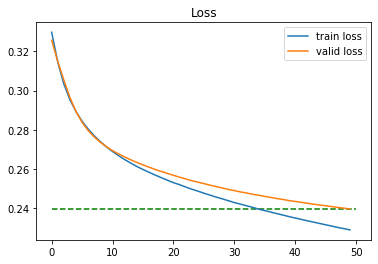

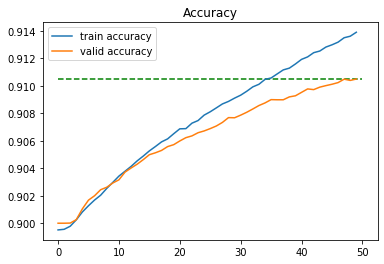

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='green', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='green', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

In [44]:
from sklearn.metrics import accuracy_score

final_model_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=pred_final.argmax(axis=-1))
loadback_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=pred_loadback.argmax(axis=-1))

print("Accuracy of final weights: %.3f" % final_model_acc)
print("Accuracy of best weights: %.3f" % loadback_acc)

Accuracy of final weights: 0.440
Accuracy of best weights: 0.440


In [47]:
new_model = build_mlp(input_shape=x_train.shape)
new_model_pred = new_model.predict(x_test)
new_model_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=new_model_pred.argmax(axis=-1))
print("Accuracy of best weights: %.3f" % new_model_acc)

new_model.load_weights("./model_weights.h5")
new_model_pred = new_model.predict(x_test)
new_model_loadback_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=new_model_pred.argmax(axis=-1))
print("Accuracy of loadback best weights: %.3f" % new_model_loadback_acc)

Accuracy of best weights: 0.107
Accuracy of loadback best weights: 0.440
